# Modelo de deep learning fast.ai para a detecção de neoplasias cutâneas

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls

drive  sample_data


# Bibliotecas e Banco de Dados

In [ ]:
#Carregar toda vez que acionar a biblioteca FASTAI 
#Recarregar notebook quaisquer alterações feitas em qualquer biblioteca usada.
%reload_ext autoreload
%autoreload 2
#Garantir que todos os gráficos plotados sejam mostrados
%matplotlib inline

In [ ]:
#Carga bibliotecas
from fastai.vision.all import *
from fastai.metrics import *
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import os
from glob import glob
import seaborn as sns

In [ ]:
base_skin_dir = os.path.join('', 'drive/MyDrive/archive')

#Banco de metadados de imagens
csv_path = "drive/MyDrive/archive/HAM10000_metadata.csv"
skin_df = pd.read_csv(csv_path)

# Análise Exporatória de Dados

In [ ]:
# Amostra descritiva do banco de imagens
skin_df.sort_values(by="image_id")

,lesion_id,image_id,dx,dx_type,age,sex,localization
4349,HAM_0000550,ISIC_0024306,nv,follow_up,45.0,male,trunk
4263,HAM_0003577,ISIC_0024307,nv,follow_up,50.0,male,lower extremity
4217,HAM_0001477,ISIC_0024308,nv,follow_up,55.0,female,trunk
3587,HAM_0000484,ISIC_0024309,nv,follow_up,40.0,male,trunk
1451,HAM_0003350,ISIC_0024310,mel,histo,60.0,male,chest
...,...,...,...,...,...,...,...
1721,HAM_0004304,ISIC_0034316,mel,histo,85.0,male,upper extremity
1888,HAM_0006376,ISIC_0034317,mel,histo,70.0,female,lower extremity
121,HAM_0000344,ISIC_0034318,bkl,histo,55.0,male,trunk
7440,HAM_0000747,ISIC_0034319,nv,histo,30.0,male,trunk


In [ ]:
# Contagem de imagens por neoplasia
dx = skin_df['dx'].value_counts().sort_index()
print(dx)

akiec     327
bcc       514
bkl      1099
df        115
mel      1113
nv       6705
vasc      142
Name: dx, dtype: int64


In [ ]:
# Contagem de imagens por categorias de neoplasia
categories = dx.index.values
print(categories)

counts = dx.values
print(counts)

['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']
[ 327  514 1099  115 1113 6705  142]


In [ ]:
#Estatísticas básicas dos dados
skin_df.describe(exclude=[np.number])

,lesion_id,image_id,dx,dx_type,sex,localization
count,10015,10015,10015,10015,10015,10015
unique,7470,10015,7,4,3,15
top,HAM_0003789,ISIC_0027419,nv,histo,male,back
freq,6,1,6705,5340,5406,2192


In [ ]:
#Identificacao da estrutura do banco de dados
skin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


Podemos observar que não há valores nulos

In [ ]:
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'nevos melanocíticos',
    'mel': 'dermatofibroma',
    'bkl': 'Lesões semelhantes a ceratose benigna',
    'bcc': 'Carcinoma basocelular',
    'akiec': 'Queratose actínica',
    'vasc': 'lesões vasculares',
    'df': 'Dermatofibroma'
}

In [ ]:
tile_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))
tile_df['path'] = tile_df['image_id'].map(imageid_path_dict.get)
tile_df['cell_type'] = tile_df['dx'].map(lesion_type_dict.get) 
tile_df['cell_type_idx'] = pd.Categorical(tile_df['cell_type']).codes
tile_df.sample(3)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
80,HAM_0000959,ISIC_0030189,bkl,histo,75.0,female,face,drive/MyDrive/archive/HAM10000_images_part_2/ISIC_0030189.jpg,Lesões semelhantes a ceratose benigna,2
4807,HAM_0007338,ISIC_0028986,nv,follow_up,65.0,female,trunk,drive/MyDrive/archive/HAM10000_images_part_1/ISIC_0028986.jpg,nevos melanocíticos,6
3698,HAM_0005219,ISIC_0027935,nv,follow_up,35.0,female,upper extremity,drive/MyDrive/archive/HAM10000_images_part_1/ISIC_0027935.jpg,nevos melanocíticos,6


Text(0.5, 1.0, 'Figura 5: Histograma de Idade dos Pacientes')

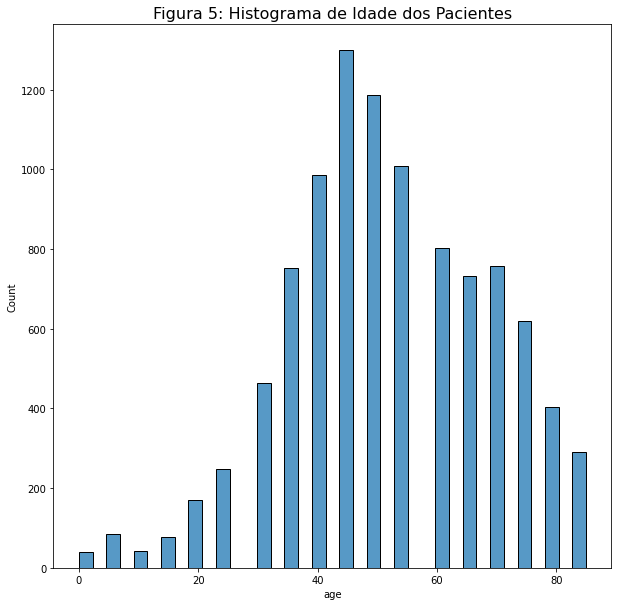

In [ ]:
bar, ax = plt.subplots(figsize=(10,10))
sns.histplot(skin_df['age'])
plt.title('Figura 5: Histograma de Idade dos Pacientes', size=16)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text major ticklabel objects>)

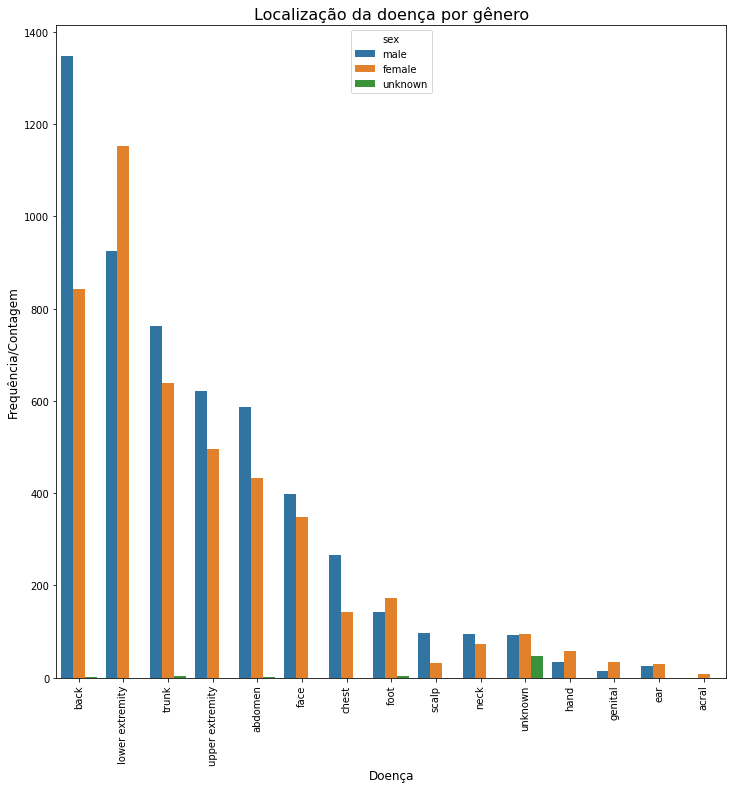

In [ ]:
value = skin_df[['localization', 'sex']].value_counts().to_frame()
value.reset_index(level=[1,0 ], inplace=True)
temp = value.rename(columns = {'localization':'location', 0: 'count'})

bar, ax = plt.subplots(figsize = (12, 12))
sns.barplot(x = 'location',  y='count', hue = 'sex', data = temp)
plt.title('Localização da doença por gênero', size = 16)
plt.xlabel('Doença', size=12)
plt.ylabel('Frequência/Contagem', size=12)
plt.xticks(rotation = 90)

# Amostra estatística de 1000 registros

In [ ]:
# Definindo o gráfico de coluna por distribuição
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # Para fins de exibição, escolha colunas que tenham entre 1 e 50 valores exclusivos
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('qde')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [ ]:
# Gerando a amostra
df1 = skin_df.sample(n=1000, random_state=1)

df1.dataframeName = 'HAM10000_metadata.csv'
nRow, nCol = df1.shape
print(f'Há {nRow} linhas e {nCol} colunas')

Há 1000 linhas e 7 colunas


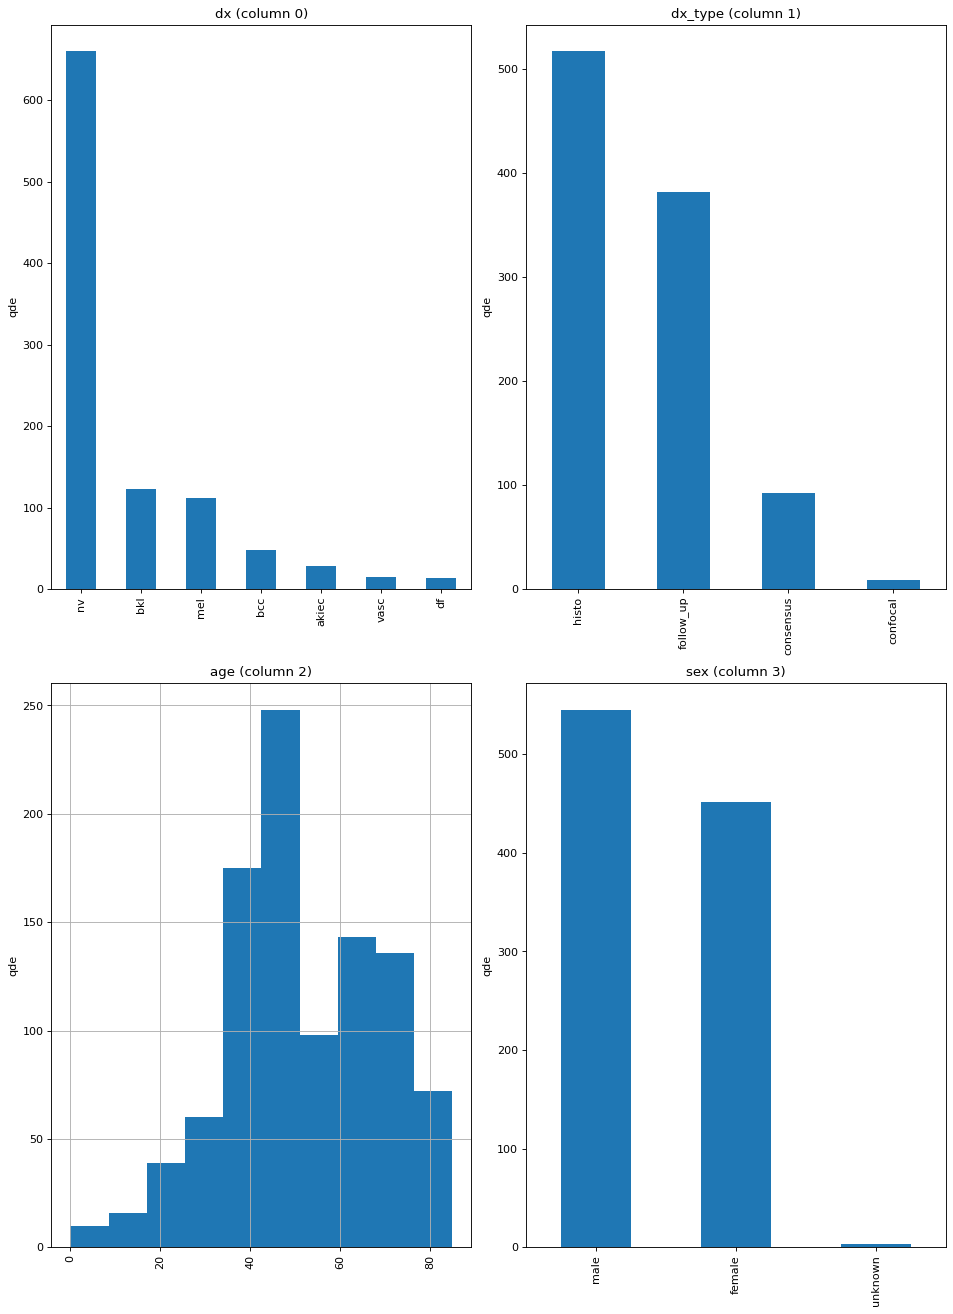

In [ ]:
plotPerColumnDistribution(df1, 4, 2)

# Verificando o equilíbrio dos dados

In [ ]:
categories = ['Queratoses actínicas', 'Carcinoma basocelular', 'Queratose benigna', 'Dermatofibroma', 'Melanoma maligno', 'Nevos melanocíticos', 'Lesões vasculares']

num_classes = len(categories)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_equilibre(categories, counts):

    plt.figure(figsize=(12, 8))

    sns_bar = sns.barplot(x=categories, y=counts, saturation=0.75, palette = "flare")
    sns_bar.set_xticklabels(categories, rotation=45)

    plt.title('Equilíbrio dos dados de treino')
    plt.show()

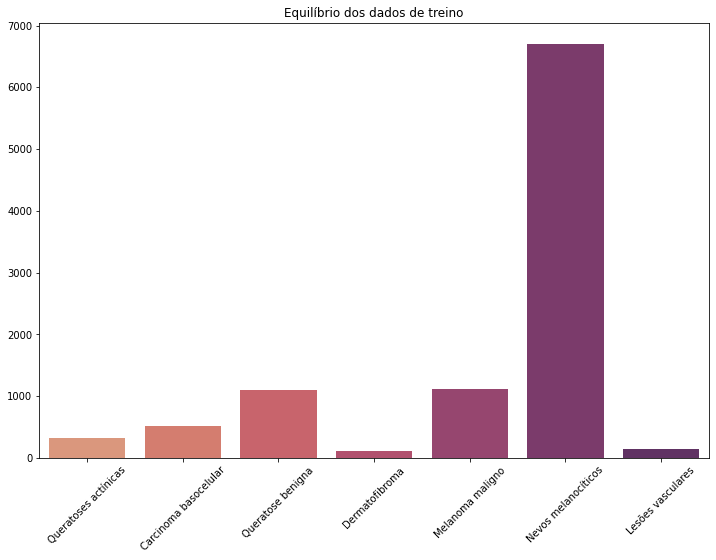

In [ ]:
plot_equilibre(categories, counts)

In [ ]:
#Definindo a localização das imagens
path = Path('drive/MyDrive/archive/')
Path.BASE_PATH = path
path.ls()

(#7) [Path('HAM10000_metadata.csv'),Path('hmnist_28_28_L.csv'),Path('hmnist_28_28_RGB.csv'),Path('hmnist_8_8_L.csv'),Path('hmnist_8_8_RGB.csv'),Path('HAM10000_images_part_1'),Path('HAM10000_images_part_2')]

## Renomeando variáveis

In [ ]:
short_to_full_name_dict = {
    "akiec" : "Doença de Bowen", # forma muito precoce de câncer de pele
    "bcc" : "carcinoma basocelular" , # câncer basocelular ou câncer de pele branca
    "bkl" : "lesões semelhantes a ceratose benigna", # tumor de pele não canceroso
    "df" : "dermatofibroma", # saliências arredondadas não cancerosas
    "mel" : "melanoma", # câncer de pele
    "nv" : "nevos melanocíticos", # mole não canceroso
    "vasc" : "lesões vasculares", # condição da pele
}

# Obtendo imagens do arquivo

In [ ]:
# retorna apenas a coluna dx e id da imagem
img_to_class_dict = skin_df.loc[:, ["image_id", "dx"]] 
# retorna colunas como listas em um dict
img_to_class_dict = img_to_class_dict.to_dict('list')  
# retorna um id de imagem de mapeamento dict para o nome da doença
img_to_class_dict = {img_id : short_to_full_name_dict[disease] for img_id,disease in zip(img_to_class_dict['image_id'], img_to_class_dict['dx']) } 
[x for x in img_to_class_dict.items()][:5]

[('ISIC_0027419', 'benign keratosis-like lesions'),
 ('ISIC_0025030', 'benign keratosis-like lesions'),
 ('ISIC_0026769', 'benign keratosis-like lesions'),
 ('ISIC_0025661', 'benign keratosis-like lesions'),
 ('ISIC_0031633', 'benign keratosis-like lesions')]

In [ ]:
# path.stem retorna o nome do arquivo sem sufixo
def get_label_from_dict(path):
    return img_to_class_dict[path.stem] 

# Construindo um bloco de imagens DataBlock

In [ ]:
dblock = DataBlock(
    # Designação das variáveis ​​independentes e dependentes
    blocks = (ImageBlock, CategoryBlock), 
    # Para obter uma lista desses arquivos e retornar uma lista de todas as imagens nesse caminho
    get_items = get_image_files, 
    # Divida nossos conjuntos de treinamento e validação aleatoriamente
    splitter = RandomSplitter(valid_pct=0.2, seed=42),
    # Estamos dizendo ao fastai qual função chamar para criar os rótulos em nosso conjunto de dados, no nosso caso é uma variável independente
    get_y = get_label_from_dict,
    # DihedralItem todas as 4 rotações de 90 graus e para cada:
    # 2 flips horizontais -> 8 orientações
    item_tfms=[Resize(448), DihedralItem()],
    # Escolhe um recorte escalado aleatório de uma imagem e a redimensiona para o tamanho
    batch_tfms=RandomResizedCrop(size=224, min_scale=0.75, max_scale=1.0))

img_path = "drive/MyDrive/archive/HAM10000_images_part_1"
# cria dataloader usando img_path  
dls = dblock.dataloaders(img_path, bs=64) # bs = tamanho do lote

# Visualizando as imagens

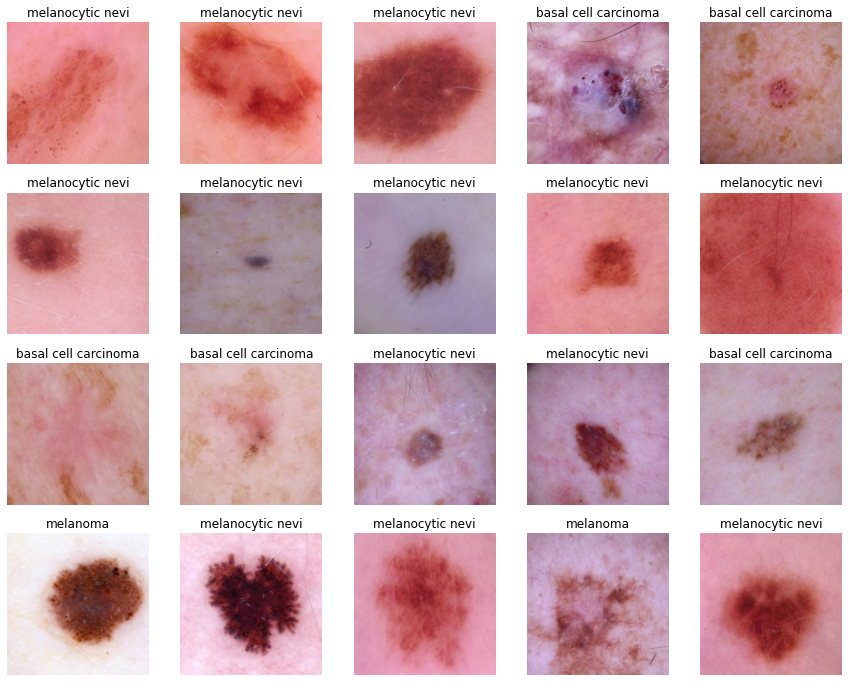

In [ ]:
dls.show_batch(max_n=20)

Observações dessas imagens serão anotadas abaixo. Primeiro, farei mais algumas verificações para confirmar que nossas categorias são apenas "doença de Bowen", 'carcinoma basocelular', 'lesões semelhantes a ceratose benigna', 'dermatofibroma', 'nevos melanocíticos', 'melanoma', 'lesões vasculares ':

In [ ]:
print(dls.vocab)

["Bowen's disease", 'basal cell carcinoma', 'benign keratosis-like lesions', 'dermatofibroma', 'melanocytic nevi', 'melanoma', 'vascular lesions']


Vamos visualizar o tamanho dos nossos conjuntos de dados:

In [ ]:
len(dls.train_ds), len(dls.valid_ds)

(4000, 1000)

# Treine um modelo simples

In [ ]:
learn = vision_learner(dls,
                    resnet18,
                    metrics=accuracy)
weights='IMAGENET1K_V1'
learn.fine_tune(4)

epoch,train_loss,valid_loss,accuracy,time
0,2.107257,1.014550,0.733000,01:19


epoch,train_loss,valid_loss,accuracy,time
0,1.162495,0.803819,0.793000,01:23
1,0.910802,0.594211,0.835000,01:22
2,0.679382,0.481674,0.837000,01:23
3,0.553778,0.479971,0.841000,01:22


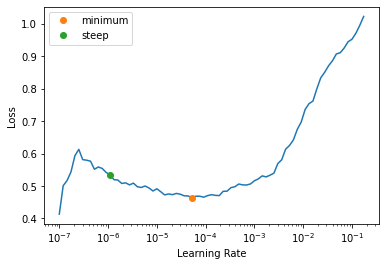

In [ ]:
# Definindo a taxa de aprendizagem em relação as perdas
lr_min,lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

In [ ]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 5.25e-06, steepest point: 1.10e-06


**treinando fit_one_cycle por 3 ciclos para ter uma ideia de quão preciso seria o modelo com resnet34.**

In [ ]:
learn = vision_learner(dls,resnet34, metrics = accuracy) 
weights='IMAGENET1K_V1'
learn.fit_one_cycle(3,1e-2) 

epoch,train_loss,valid_loss,accuracy,time
0,1.484736,1.193570,0.713000,01:26
1,0.915688,0.601399,0.812000,01:39
2,0.632683,0.461788,0.835000,01:28


Aplicando o algoritmo Resnet34 observamos uma taxa de acurácia de 83,5 %

# Descongelamento e Transferência de Aprendizagem

In [ ]:
learn.unfreeze()

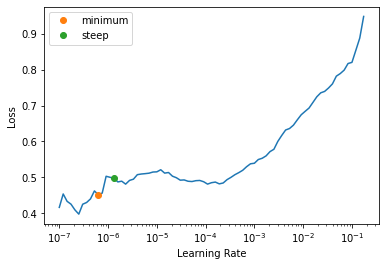

In [ ]:
lr_min,lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

In [ ]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 6.31e-08, steepest point: 1.32e-06


In [ ]:
learn.fit_one_cycle(30 ,lr_max=slice(1e-4, 1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.511097,0.513052,0.824000,01:39
1,0.503994,0.662045,0.796000,01:44
2,0.514480,0.839405,0.729000,01:41
3,0.530039,0.771729,0.793000,01:36
4,0.558221,0.647117,0.794000,01:45
5,0.567121,0.679792,0.792000,01:35
6,0.575276,0.434001,0.852000,01:36
7,0.539968,4.668460,0.733000,01:35
8,0.536520,0.603031,0.791000,01:34
9,0.484933,0.473026,0.845000,01:36


In [ ]:
O modelo com fast.ai chegou a taxa de 91,1%

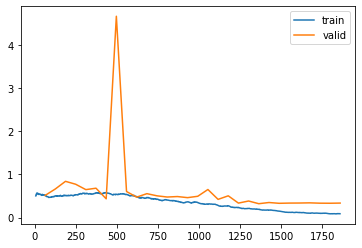

In [ ]:
learn.recorder.plot_loss()

### salvando o modelo

In [ ]:
learn.save('model1')

Path('models/model1.pth')

# Interpretação do modelo

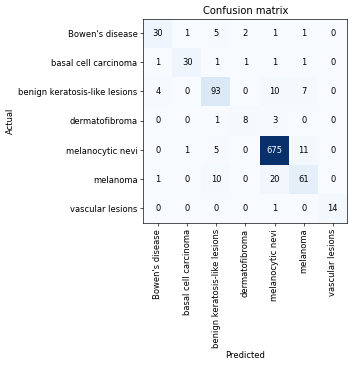

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

# As 6 principais perdas

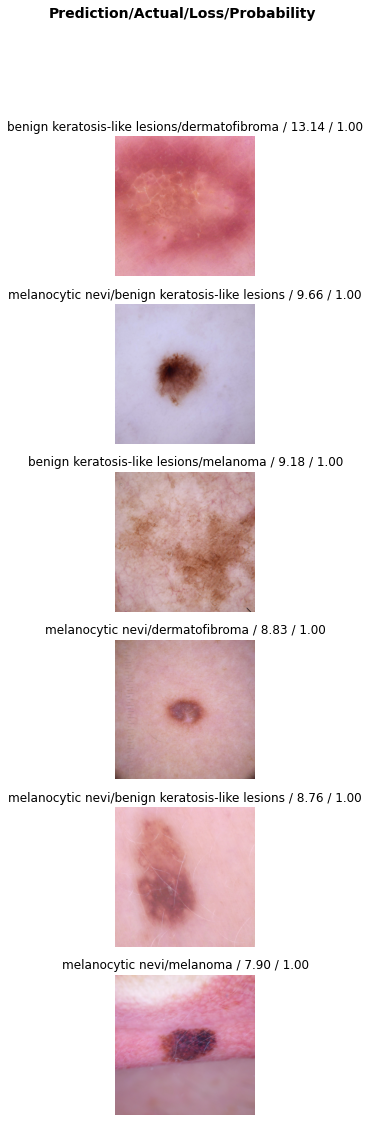

In [ ]:
interp.plot_top_losses(6, nrows=6)

In [2]:
!jupyter nbconvert --to html /content/neoplasias_cutaneas_fastai.ipynb

[NbConvertApp] Converting notebook /content/neoplasias_cutaneas_fastai.ipynb to html
[NbConvertApp] Writing 1756122 bytes to /content/neoplasias_cutaneas_fastai.html


# Referências

https://www.kaggle.com/code/ahedjneed/skin-cancer-classifier-with-fastai-acc-97

https://www.kaggle.com/code/leonblum/ham10000-vision-resnet18-97-7-accuracy/notebook

https://www.kaggle.com/code/rkuo2000/skin-lesion-classification

https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000/code?resource=download

https://www.kaggle.com/code/rslu2000/skin-cancer-model-97-88-accuracy

https://www.kaggle.com/code/kmader/dermatology-mnist-loading-and-processing

https://www.kaggle.com/code/dhruv1234/ham10000-skin-disease-classification

